# An Introduction to Generalized Linear Models (Fourth Edition)

In [30]:
import time
import math
import torch
import numpy
import scipy
import pandas
from scipy import stats
from scipy.stats import norm
from numpy.linalg import inv
import matplotlib.pyplot as plt

%matplotlib inline

## 4.2 Example: Failure times for pressure vessels

In [2]:
lifetime = numpy.array([1051, 4921, 7886, 10861, 13520,
1337, 5445, 8108, 11026, 13670,
1389, 5620, 8546, 11214, 14110,
1921, 5817, 8666, 11362, 14496,
1942, 5905, 8831, 11604, 15395,
2322, 5956, 9106, 11608, 16179,
3629, 6068, 9711, 11745, 17092,
4006, 6121, 9806, 11762, 17568,
4012, 6473, 10205, 11895, 17568,
4063, 7501, 10396, 12044])

In [3]:
theta = lifetime.mean()
weibull_probability = (2 * lifetime/theta**2) * numpy.exp(-(lifetime/theta)**2)


In [4]:
def newton_raphson_weibull(observed_data, initial_param):
    
    theta_m_1     = initial_param
    n             = observed_data.size
    theta_list    = []
    u_prime_list  = []
    diff          = 1
    while diff > 0.01: 
        u         = ((-2*n)/theta_m_1)    + ((2/theta_m_1**3) * (observed_data**2).sum())

        u_prime   = ((-2*n)/theta_m_1**2) - ((6/theta_m_1**4) * (observed_data**2).sum())
        
        theta_m   = theta_m_1 - u/u_prime
        
        diff      = abs(theta_m_1 - theta_m)
        
        # Note that replacing the old value with the new value must happen after the "diff" line.
        theta_m_1 = theta_m
                
        theta_list.append(theta_m)
        u_prime_list.append(u_prime)
    return numpy.array(theta_list), numpy.array(u_prime_list)
    

In [5]:
theta_value, u_prime_diss = newton_raphson_weibull(lifetime, 1)
theta_value

array([1.33333333e+00, 1.77777776e+00, 2.37037032e+00, 3.16049370e+00,
       4.21399146e+00, 5.61865494e+00, 7.49153912e+00, 9.98871691e+00,
       1.33182847e+01, 1.77577022e+01, 2.36769108e+01, 3.15691541e+01,
       4.20920626e+01, 5.61224114e+01, 7.48290791e+01, 9.97702024e+01,
       1.33022426e+02, 1.77352545e+02, 2.36444726e+02, 3.15199608e+02,
       4.20123963e+02, 5.59828691e+02, 7.45642213e+02, 9.92310285e+02,
       1.31865733e+03, 1.74785681e+03, 2.30647332e+03, 3.02056095e+03,
       3.90601856e+03, 4.95072891e+03, 6.09232503e+03, 7.21134642e+03,
       8.16818020e+03, 8.87407875e+03, 9.32946537e+03, 9.59459556e+03,
       9.73887706e+03, 9.81433452e+03, 9.85294880e+03, 9.87248495e+03,
       9.88231128e+03, 9.88723913e+03, 9.88970674e+03, 9.89094147e+03,
       9.89155907e+03, 9.89186792e+03, 9.89202237e+03, 9.89209959e+03,
       9.89213821e+03, 9.89215751e+03, 9.89216717e+03])

## Applying Hessian and Jacobina methods to the same problem

In [6]:
def log_likelihood_weibull(param, y_data = torch.from_numpy(lifetime), lam = torch.Tensor([2])):
    
    log_likelihood = ((lam - 1)*torch.log(y_data) + torch.log(lam) - lam * torch.log(param) - \
                      (y_data/param)**lam).sum()
    
    return log_likelihood

In [7]:
def curvature_matrix(parameter_array):
    
    curvature   = torch.autograd.functional.hessian(log_likelihood_weibull, (parameter_array))
    
    return curvature

In [8]:
def jacobian_matrix(parameter_array):
    
    jacobian    = torch.autograd.functional.jacobian(log_likelihood_weibull, (parameter_array))
    
    return jacobian

In [9]:
def newton_raphson_weibull_v2(observed_data, initial_param):
    
    theta_m_1     = initial_param
    n             = observed_data.size()
    theta_list    = []
    diff          = 1
    while diff > 0.01: 
        u         = jacobian_matrix(theta_m_1)[0]
        
        #u_primt (below) is calculated according to eq. 4.7 
        u_prime   = curvature_matrix(theta_m_1)[0][0]

        theta_m   = theta_m_1 - u/u_prime
        
        # Accoring to eq. 4. 10 of Dobson, u_prime can be approximated good with E[u_prime].
        # You can uncomment the print line to see that this is true!
        u_prime_ap= torch.Tensor([4])*torch.Tensor([n])/torch.Tensor([theta_m_1])**2
        
#         print(u_prime, u_prime_ap)
        
        diff      = abs(theta_m_1 - theta_m)
                
        # Note that replacing the old value with the new value must happen after the "diff" line.
        theta_m_1 = theta_m
                
        theta_list.append(theta_m)
        
    return torch.Tensor(theta_list), -u_prime
    

In [10]:
theta_value_torch, J = newton_raphson_weibull_v2(torch.from_numpy(lifetime), torch.Tensor([800]))
theta_value_torch

tensor([1065.5015, 1417.9109, 1884.0295, 2496.6667, 3292.7808, 4306.1895,
        5548.0239, 6964.1304, 8366.6973, 9409.0938, 9836.9805, 9891.4131,
        9892.1768, 9892.1768])

### Standard error of $\theta$ and confidence interval (with the assumption thata sampling distribution of $\hat{\theta}$ is normal (or approximately normal))

In [183]:
se       = numpy.sqrt(1/J)
CI_right = theta_value_torch[-1] + 1.96 *se
CI_left  = theta_value_torch[-1] - 1.96 *se

print(CI_left, CI_right)

tensor(8507.2715) tensor(11277.0820)


### Cheking the assumption of normaility (using quadratic approximation)

In [216]:
def theta_log_likelihood_quadratic_approximation(theta_data, theta_hat, observed_fisher_information):
    quadratic_theta_out_list = []
    for theta_value in theta_data:
        quadratic_app = -0.5 * observed_fisher_information * (theta_value - theta_hat)**2
        
        quadratic_theta_out_list.append(quadratic_app)
    
    return numpy.array(quadratic_theta_out_list)

In [217]:
theta_range         = numpy.linspace(7000, 13000, 6000)
quadratic_theta_app = theta_log_likelihood_quadratic_approximation(theta_range, 9892.1768, J)

In [205]:
def theta_log_likelihood(observed_data, theta_data, lam = torch.Tensor([2])):
    
    theta_out_list = []
    for theta_value in theta_data:
        theta_log_likelihood = ((lam - 1)*torch.log(observed_data) + torch.log(lam) - lam * torch.log(theta_value) - \
                      (observed_data/theta_value)**lam).sum()
        
        theta_out_list.append(theta_log_likelihood)
    
    return numpy.array(theta_out_list)

In [206]:
theta_range      = numpy.linspace(7000, 13000, 6000)
theta_likelihood = theta_log_likelihood(torch.from_numpy(lifetime), torch.from_numpy(theta_range))

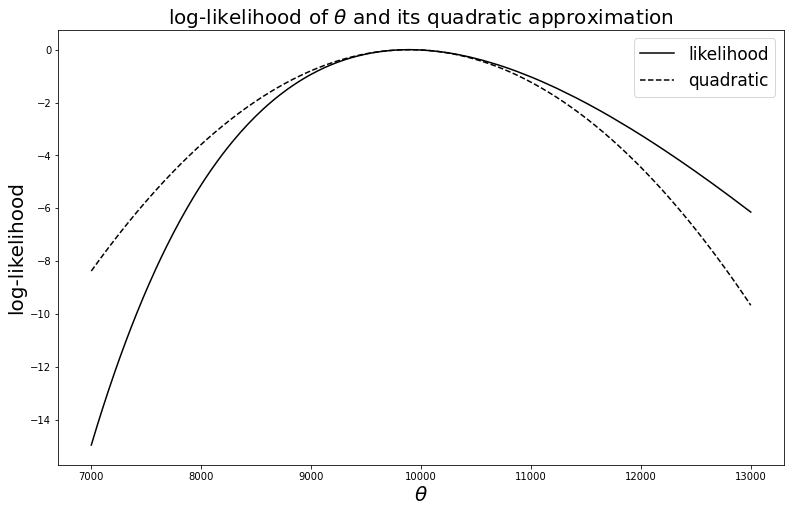

In [251]:
fig, ax = plt.subplots(1, 1, figsize = (13, 8))

# according to Pawitan, page 33, we can write log(L(theta)/L(theta_hata)) = log(L(theta)) - log(L(theta_hat).)
ax.plot(theta_range, theta_likelihood - theta_likelihood.max(), 'k-')

ax.plot(theta_range, quadratic_theta_app, 'k--')


ax.set_xlabel(r"$\theta$", fontsize = 20)

ax.set_ylabel("log-likelihood", fontsize = 20)

ax.set_title(r"log-likelihood of $\theta$ and its quadratic approximation", fontsize = 20)

ax.legend(["likelihood", "quadratic"], fontsize = 17)

# ax.set_xlim(9000, 11000)


### Conclusion

Given the plot above (and as it is written in the book), there is not a good fit between the quadratic approximation and the likelihood function. Also, in the value of the curvature (i.e. observed Fisher information; $\Im$) is very small ($2.0030e-06$) which means the log-likelihood curve is approximatly flat for a wide interval of $\theta$ values. In this case $\hat{\theta}$ is not well determined and its standard error is large ($se = 706.58$).

# 4.4 Poisson regression example

In [2]:
x_array = numpy.array([-1, -1, 0, 0, 0, 0, 1, 1, 1])
y_array = numpy.array([2, 3, 6, 7, 8, 9, 10, 12, 15])

In [3]:
def j_matrix_function(y_data, x_data, b_one, b_two):
    
    j_00  = (1 / (b_one + b_two * x_data)).sum()
    j_01  = (x_data / (b_one + b_two * x_data)).sum()
    j_10  = j_01
    j_11  = (x_data**2 / (b_one + b_two * x_data)).sum()

    jz_00 = (y_data / (b_one + b_two  * x_data)).sum()
    jz_10 = (y_data * x_data / (b_one + b_two * x_data)).sum()

    j_matrix_out  = numpy.array([j_00, j_01, j_10, j_11]).reshape(2,2)
    jz_matrix_out = numpy.array([jz_00, jz_10]).reshape(2,1)
    
    return j_matrix_out, jz_matrix_out

In [7]:
def poisson_iterative_function(y_data, x_data, ini_b_one, ini_b_two):
    
    b_one    = ini_b_one
    b_two    = ini_b_two
    diff_one = 1
    # This condition alone is not good enough since it meet the condtion > 0.01 while the other parameter 
    # has not converged yet!
    while diff_one > 0.01:
        
        j_matrix, jz_matrix = j_matrix_function(y_data, x_data, b_one, b_two)

        b_00, b_10   = inv(j_matrix) @ jz_matrix

        diff_one     = abs(b_00 - b_one)
        
        b_one, b_two = b_00, b_10

    # final coefficient matrix
    b_matrix         = numpy.array([b_one, b_two]).reshape(2,1)
    
    # final fisher informatin matrix evaluated at MLE values!
    j_matrix, _      = j_matrix_function(y_data, x_data, b_one, b_two)
    j_matrix_inverse = inv(j_matrix)
    
    return b_matrix, j_matrix_inverse

In [8]:
b_matrix, j_inverse  = poisson_iterative_function(y_array, x_array, 7, 5)
print(b_matrix)
print(j_inverse)

[[7.45163181]
 [4.93531374]]
[[0.781675   0.41655685]
 [0.41655685 1.18630213]]


## 6.3.1 Example: Carbohydrate diet

In [118]:
input_data = numpy.array([
[33, 33, 100, 14],
[40, 47, 92, 15],
[37, 49, 135, 18],
[27, 35, 144, 12],
[30, 46, 140, 15],
[43, 52, 101, 15],
[34, 62, 95, 14],
[48, 23, 101, 17],
[30, 32, 98, 15],
[38, 42, 105, 14],
[50, 31, 108, 17],
[51, 61, 85, 19],
[30, 63, 130, 19],
[36, 40, 127, 20],
[41, 50, 109, 15],
[42, 64, 107, 16],
[46, 56, 117, 18],
[24, 61, 100, 13],
[35, 48, 118, 18],
[37, 28, 102, 14]])

carbohydrate = input_data[:, 0].reshape(20, 1)
age          = input_data[:, 1].reshape(20, 1)
weight       = input_data[:, 2].reshape(20, 1)
protein      = input_data[:, 3].reshape(20, 1)
intercept    = numpy.ones(20).reshape(20, 1)
design_matrix= numpy.concatenate([intercept, age, weight, protein], -1)
X            = design_matrix
y            = carbohydrate
yT           = numpy.transpose(y)
XT           = numpy.transpose(X)

In [94]:
xT_x = numpy.transpose(X) @ X
xT_y = numpy.transpose(X) @ y 
b    = inv(xT_x)@xT_y # note the order (first inverse then the other one)!
b

array([[36.96005591],
       [-0.11367636],
       [-0.22801736],
       [ 1.95771257]])

In [116]:
# Residual sum of squares
numpy.transpose((y - X@b))@((y - X@b))

array([[567.66285733]])

In [115]:
# Standard error of "b" from eq. 5.10 (remember that we need J**(-1) and the sqrt of its diagonal element!)
# Also, note that I used 35.479 as the value of sigma**2 (variance) amd I took it from the book but I could 
# have easily calculated it from eq. 6.4.
numpy.sqrt((35.479) * inv(xT_x))

/tmp/ipykernel_1355142/93197094.py:2: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt((35.479) * inv(xT_x))


array([[13.07129609,         nan,         nan,         nan],
       [        nan,  0.10932559,  0.02587612,         nan],
       [        nan,  0.02587612,  0.08328903,         nan],
       [        nan,         nan,         nan,  0.6348935 ]])

In [119]:
# Deviance of model 6.6 using equation 6.5
D = (1/35.479) * (yT@y - numpy.transpose(b)@XT@y)
D

array([[15.99996779]])

In [265]:
# Predicted valaues
# To find the predicted valaues we need to use the estimated beta values above (the "b" vector).
# Note that the coefficients values in the book are rounded up but I am not rounding them so my predicted 
# values are slightly different!
y_p   = 36.96 - 0.113*age - 0.228*weight + 1.957*protein

# Residuals
e_hat = y - y_p

# Standardized residuals (see page 102)
H     = X@inv(XT@X)@XT
r     = e_hat[:, 0]/(numpy.sqrt(35.479)*numpy.sqrt(1 - H.diagonal()))

# DFITS
dfits = r*numpy.sqrt(H.diagonal()/(1 - H.diagonal()))

# Cook's distance
# Note that here I set "p" (the number of parameters of the model) to 4 for beta_nul, one, two, and three!
cook  = (1/4)*(H.diagonal()/(1 - H.diagonal()))*(r**2)

# order of observation array
order = numpy.array(range(1, 21))

### Reproduced table 6.6

In [266]:
table_6_6 = pandas.DataFrame({"Observation":order, "Carboydrate":y[:, 0], "Fitted value":y_p[:, 0], \
                              "Residual":e_hat[:, 0],"Std residual": r, "DFITS":dfits, "Cook's distance":cook})
table_6_6

,Observation,Carboydrate,Fitted value,Residual,Std residual,DFITS,Cook's distance
0,1,33,37.829,-4.829,-0.878107,-0.365386,3.337672e-02
1,2,40,40.028,-0.028,-0.005011,-0.001849,8.548113e-07
2,3,37,35.869,1.131,0.211243,0.102986,2.651540e-03
3,4,27,23.657,3.343,0.789416,0.780838,1.524269e-01
4,5,30,29.197,0.803,0.154566,0.086685,1.878553e-03
5,6,43,37.411,5.589,0.982015,0.303178,2.297928e-02
6,7,34,35.692,-1.692,-0.322497,-0.173344,7.512048e-03
7,8,48,44.602,3.398,0.680077,0.441344,4.869604e-02
8,9,30,40.355,-10.355,-1.885063,-0.790316,1.561499e-01
9,10,38,35.672,2.328,0.410320,0.131158,4.300631e-03


### Figure 6. 1 Diagnostic plots for Model (6.6)

In [260]:
quantile_range  = numpy.linspace(0.05, 1, 20)

normal_data     = numpy.random.normal(0, 1, 100)

normal_quantile = numpy.quantile(normal_data, quantile_range)

test_x          = numpy.linspace(-2, 2, 100)
test_y          = numpy.linspace(-2, 2, 100)

Text(0, 0.5, 'Standardized residuals ')

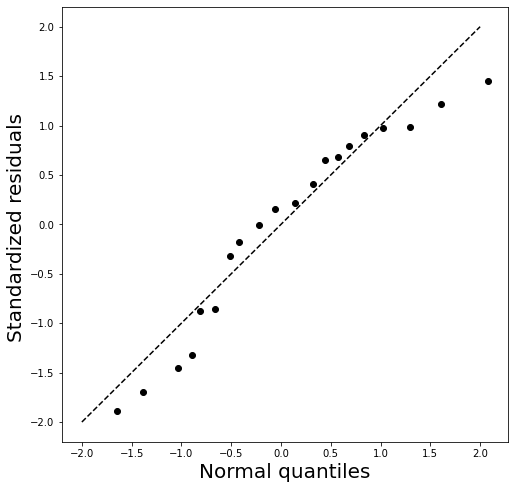

In [261]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

ax.plot(normal_quantile, numpy.sort(r), 'ko')

ax.plot(test_x, test_y, 'k--')

ax.set_xlabel(r"Normal quantiles", fontsize = 20)

ax.set_ylabel("Standardized residuals ", fontsize = 20)

Text(0, 0.5, 'Standardized residuals ')

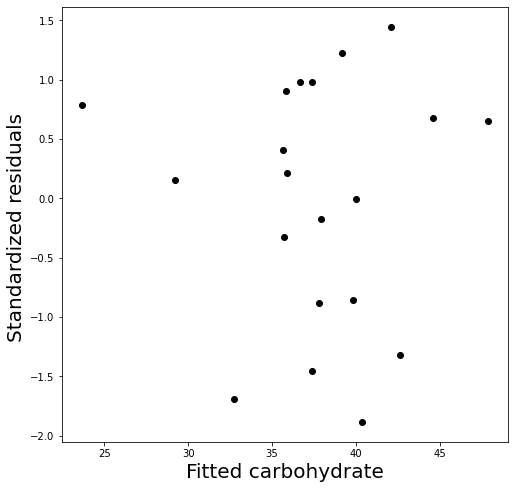

In [186]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

ax.plot(y_p[:, 0], r, 'ko')

ax.set_xlabel(r"Fitted carbohydrate", fontsize = 20)

ax.set_ylabel("Standardized residuals ", fontsize = 20)

(0.5, 20.5)

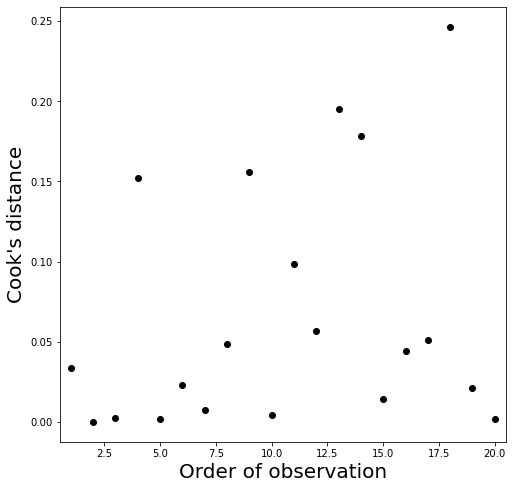

In [267]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

ax.plot(order, cook, 'ko')

ax.set_xlabel(r"Order of observation", fontsize = 20)

ax.set_ylabel("Cook's distance", fontsize = 20)

ax.set_xlim(0.5, 20.5)

## Coefficient of determination, $R^2$

In [270]:
# coefficient of determination page 111.
r_2 = (numpy.transpose(b)@XT@y - 20*y.mean()**2)/(numpy.transpose(y)@y - 20*y.mean()**2)
r_2

array([[0.48054277]])

## 7.3.1 Example: Beetle mortality

In [11]:
dose    = numpy.array([1.6907, 1.7247, 1.7552, 1.7842, 1.8113, 1.8369, 1.8610, 1.8839])
beetles = numpy.array([59, 60, 62, 56, 63, 59, 62, 60])
killed  = numpy.array([6, 13, 18, 28, 52, 53, 61, 60])
p_i     = killed/beetles
com     = numpy.array([math.comb(beetles[i], killed[i]) for i in range(killed.size)])

In [22]:
def logistic_log_likelihood(param, y_observed = torch.from_numpy(killed), x_predictor = torch.from_numpy(dose), \
                            total_number = torch.from_numpy(beetles), combination = torch.from_numpy(com)):
    
    # Note that for the sake of the similariy of the results I had to remove the combination term in 
    # in the log-likelihood function of the Binomial distribution. Read page 156 of Dobson!
    log_likeli = (y_observed * (param[0] + param[1] * x_predictor) - total_number * torch.log(1 + \
                        torch.exp(param[0] + param[1] * x_predictor))).sum()
    
#     log_likeli = (y_observed * (param[0] + param[1]*x_predictor) - n * torch.log(1 + \
#                         torch.exp(param[0] + param[1]*x_predictor)) + torch.log(combination)).sum()
        
    return log_likeli

In [23]:
def logistic_iterative(param):

    beta_old     = param
    largest_beta = 1
    while largest_beta > 0.001:
        # Note that in torch Hessian is negative of information matrix and since here "J" represents
        # the information matrix (i.e. the variance of the u_prime; see page 55 of Dobson) we need to 
        # mulitply the result of the Hessian by a negative sign as is done below!!
        J        = -1 * torch.autograd.functional.hessian(logistic_log_likelihood, (beta_old))
        U        = torch.autograd.functional.jacobian(logistic_log_likelihood, (beta_old))
        beta_new = beta_old + U @ torch.inverse(J)
        beta_diff= abs(beta_old - beta_new)
        largest_beta = beta_diff.max()

        beta_old = beta_new
    
    return beta_old 

In [33]:
parameter_array = torch.Tensor([0.0, 0.0])
beta_cofficient = logistic_iterative(parameter_array)
beta_cofficient

tensor([-60.8588,  34.3484])

In [34]:
# To make use of the estimated beta coefficients to do the predication of the data first we 
# need to find the proportion value (i.e. pi_i) for each observation and then use that to 
# find the predicted value!
beta_vector = beta_cofficient.detach().cpu().numpy()
pi          = numpy.exp(beta_vector[0] + beta_vector[1]*dose)/(1 + numpy.exp(beta_vector[0] + \
                                                            beta_vector[1]*dose))
predicted_kill = pi * beetles
predicted_kill

array([ 3.42738884,  9.92848203, 22.39071408, 33.87123201, 50.09729812,
       53.30195799, 59.23282233, 58.75009746])

In [95]:
# Finally, we find the value of deviation (D)

2 * (killed*numpy.log(killed/predicted_kill) + (beetles - \
    killed)*(numpy.log(beetles - killed + 0.000001) - numpy.log(beetles - predicted_kill))).sum()

11.125370131278352

In [7]:
y_treatment = numpy.array([0, 1, 3, 5])
total_treat = numpy.array([5, 5, 5, 5])
x_treatment = numpy.array([-0.86, -0.30, -0.05, 0.73])
pi_treatment= y_treatment/total_treat
combination = numpy.array([math.comb(total_treat[i], y_treatment[i]) for i in range(y_treatment.size)])

In [8]:
def logistic_log_likelihood_v2(param, y_observed = torch.from_numpy(y_treatment), x_predictor = torch.from_numpy(x_treatment), \
                            total_number = torch.from_numpy(total_treat), combination = torch.from_numpy(com)):
    
    # Note that for the sake of similariy of the results I had to remove the combination term in 
    # in the log-likelihood function of the Binomial distribution. Read page 156 of Dobson!
    log_likeli = (y_observed * (param[0] + param[1] * x_predictor) - total_number * torch.log(1 + \
                        torch.exp(param[0] + param[1] * x_predictor))).sum()
    
#     log_likeli = (y_observed * (param[0] + param[1]*x_predictor) - total_number * torch.log(1 + \
#                         torch.exp(param[0] + param[1]*x_predictor)) + torch.log(combination)).sum()
        
    return log_likeli

In [9]:
def logistic_iterative_v2(param):

    beta_old     = param
    largest_beta = 1
    while largest_beta > 0.001:
        # Note that in torch Hessian is negative of information matrix and since here "J" represents
        # the information matrix (i.e. the variance of the u_prime; see page 55 of Dobson) we need to 
        # mulitply the result of the Hessian by a negative sign as is done below!!
        J        = -1 * torch.autograd.functional.hessian(logistic_log_likelihood_v2, (beta_old))
        U        = torch.autograd.functional.jacobian(logistic_log_likelihood_v2, (beta_old))
        beta_new = beta_old + U @ torch.inverse(J)
        beta_diff= abs(beta_old - beta_new)
        largest_beta = beta_diff.max()

        beta_old = beta_new
    
    return beta_old 

In [10]:
parameter_array = torch.Tensor([0.0, 0.0])
beta_cofficient = logistic_iterative_v2(parameter_array)
beta_cofficient

tensor([0.8466, 7.7488])

In [142]:
Y =stats.bernoulli(0.7).rvs(20)
print(Y)
like = stats.beta(1, 1).pdf(0.67)
print(like)
# stats.bernoulli(0.3).pmf(Y).prod()

[1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1]
0.9999999999999999


In [36]:
alpha_range = numpy.linspace(-4, 6, 100)
beta_range  = numpy.linspace(0, 30, 100)

alpha_grid, beta_grid = numpy.meshgrid(alpha_range, beta_range)

In [58]:
def alpha_beta_posterio(alpha, beta, observed_y, iteration = 5):
    
    pi_value   = alpha + beta*(20)
    prior      = 1
    likelihood_old = 1
    for i in range(observed_y.size):
        # calculating the likelihood value
        likelihood  = scipy.stats.binom.pmf(observed_y[i], p = pi_value, n = 5)
        print(likelihood)
#         likelihood_list.append(likelihood)
        total_likelihood = likelihood * likelihood_old
        old_likelihood   = likelihood
    posterior   = total_likelihood * prior
        
        
    return posterior, pi_value
    

In [ ]:
test, test_2 = alpha_beta_posterio(alpha_grid, beta_grid, y_treatment)